# Imports

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
import warnings
from src.nnsrc.dense import NeuralNetwork

warnings.filterwarnings('ignore')
sys.path.append("../")


# Functions

In [215]:
def load_dataset_class(src_path, number, simple=True, shuffle=True, seed=1):
    np.random.seed(seed)
    
    if simple == True:
        train = pd.read_csv(os.path.join(src_path, 
                                         'data.simple.train.' + str(number) + '.csv'))
        test = pd.read_csv(os.path.join(src_path, 
                                         'data.simple.test.' + str(number) + '.csv'))
        X_train = train[["x", "y"]].values
        y_train = train["cls"].values
        
        X_test = test[["x", "y"]].values
        y_test = test["cls"].values
        
    if shuffle == True:
        indices = np.arange(X_train.shape[0])
        X_train = X_train[indices]
        y_train = y_train[indices]
        
        indices = np.arange(X_test.shape[0])
        X_test = X_test[indices]
        y_test = y_test[indices]
        
    return X_train, X_test, y_train, y_test


def chceck_model_class_binary(X_train, X_test, y_train, y_test, n_times, n_epochs, batch_size=32, alpha=0.7,
                              n_layers=4,
                              n_neurons_per_layer=[2, 10,  100, 1], act_funcs=['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'],
                              bias=True, problem='classification_binary', error_function='binary_cross_entropy'):
    acc = []
    predictions = []
    history = []
    for i in range(n_times):
        seed = np.random.randint(10000)
        nn = NeuralNetwork(n_layers=n_layers, 
                           n_neurons_per_layer=n_neurons_per_layer, act_funcs=act_funcs,
                           bias=bias, problem=problem, error_function=error_function, seed=seed)
        
        nn.train(X_train, y_train, epochs=n_epochs, batch_size=batch_size, alpha=alpha)
        predictions.append(nn.predict(X_test))
        acc.append(nn.binary_accuracy(predictions[i], y_test))
        history.append(nn.history)
    return acc, predictions, history


def plot_history_predictions(history, predictions, acc, X_test, y_test, 
                             subplot_name="cost per epoch (train) | accuracy per epoch (train) | mean predictions (test) | accuracy per trial (test)",
                             append=None):
    len_hist = len(history[0]['cost'])
    plt.figure(figsize=(22, 5))
    for i in range(len(history)):
        plt.subplot(141)
        plt.plot(list(range(len_hist)), np.squeeze(history[i]['cost']).tolist())
        plt.ylabel("Cost")
        plt.xlabel("Epoch")
        
        plt.subplot(142)
        plt.plot(list(range(len_hist)), np.squeeze(history[i]['metrics']).tolist())
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
    
    n_times = len(predictions)
    pred = np.squeeze(np.asanyarray(predictions))
    pred_mean = np.mean(pred, axis=0)
    pred_mean[pred_mean > 0.5] = 1
    pred_mean[pred_mean <= 0.5] = 0
    
    diff = y_test-pred_mean
    
    diff_str = diff.astype(int).astype(str)
    diff_str[diff_str != '0'] = 'r'
    diff_str[diff_str == '0'] = 'g'
    
    plt.subplot(143)
    plt.scatter(X_test[:,0], X_test[:,1], c=diff_str, s=100)
    plt.subplot(143)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=10)
    plt.ylabel("X_1")
    plt.xlabel("X_0")
    
    plt.subplot(144)
    plt.scatter(list(range(len(history))), acc)
    plt.ylabel("accuracy")
    plt.xlabel("trial")
    if append is None:
        plt.suptitle(subplot_name)
    else:
        plt.suptitle(subplot_name + append)
    
    plt.show()
    
# def plot_history(history, subplot_name="Cost and Accuracy"):
#     len_hist = len(history[0]['cost'])
    
#     plt.figure(figsize=(9,3))
#     for i in range(len(history)):
#         plt.subplot(121)
#         plt.plot(list(range(len_hist)), np.squeeze(history[i]['cost']).tolist())
#         plt.ylabel("Cost")
#         plt.xlabel("Epoch")
        
#         plt.subplot(122)
#         plt.plot(list(range(len_hist)), np.squeeze(history[i]['metrics']).tolist())
#         plt.ylabel("Accuracy")
#         plt.xlabel("Epoch")
#     plt.suptitle(subplot_name)
#     plt.show()
    
# def print_predictions_binary(predictions, X_test, y_test):
#     n_times = len(predictions)
#     pred = np.squeeze(np.asanyarray(predictions))
#     pred_mean = np.mean(pred, axis=0)
#     pred_mean[pred_mean > 0.5] = 1
#     pred_mean[pred_mean <= 0.5] = 0
    
#     diff = y_test-pred_mean
    
#     pred_mean_str = diff.astype(int).astype(str)
#     pred_mean_str[pred_mean_str != '0'] = 'g'
#     pred_mean_str[pred_mean_str == '0'] = 'r'
    
#     plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean_str, s=100)

#     plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=10)
#     print(pred_mean_str)

In [191]:
X_train, X_test, y_train, y_test = load_dataset_class('../src/data/classification', 100)


In [192]:
y_train, y_test = y_train-1, y_test-1 

In [193]:
acc, predictions, history = chceck_model_class_binary(X_train.T, X_test.T, y_train, y_test, n_times=5, n_epochs=1000)

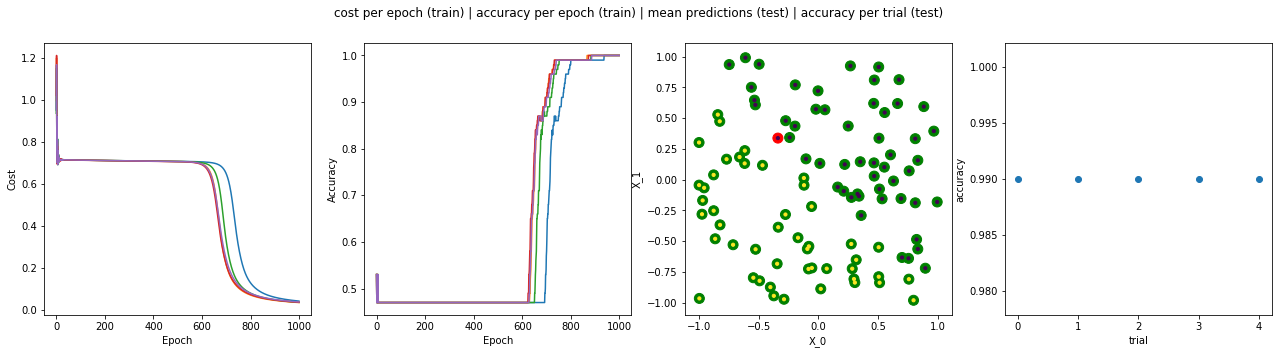

In [216]:
plot_history_predictions(history, predictions, acc, X_test, y_test)